In [1]:
import svgpathtools as spt
from svgpathtools import parse_path, Line, Path, wsvg, Arc, disvg
import numpy as np
import math

import tempfile, os
from IPython.display import SVG, display

import warnings

def disp_svg(paths):
    with tempfile.TemporaryDirectory() as tmp_dir:
        tmp_svg = os.path.join(tmp_dir, 'display.svg')
        spt.wsvg(paths, filename = tmp_svg)
        ## Possible add something like this to get transforming y-axis
        ## Possible needs a group wrapper on all objects
        # spt.wsvg(paths, filename = 'out_test.svg',svg_attributes={'transform':'matrix(1 0 0 -1 0 400)'})

        display(SVG(tmp_svg))

def save_svg(paths, name, params):
    spt.wsvg(paths,filename = f'pathout_{name}_{params}.svg', baseunit='mm',mindim=None)


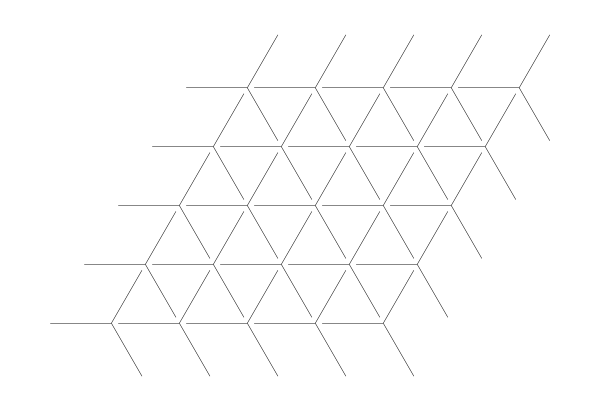

In [2]:
num_elem=3
theta=2*np.pi/num_elem

r0=0.9

paths=[]

x0 = 0
x1 = -1*r0

basis = Path()
for i in range(num_elem):
    basis.append(spt.Line(x0,x1*np.exp(-i*1j*theta)))
    

lattice = [-1*np.exp(1j*theta),1.0] ## Lattice vectors

nx=5
ny=5

for i in range(nx):
    for j in range(ny):
        paths.append(basis.translated(i*lattice[0] + j * lattice[1]))

disp_svg(paths)

1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0


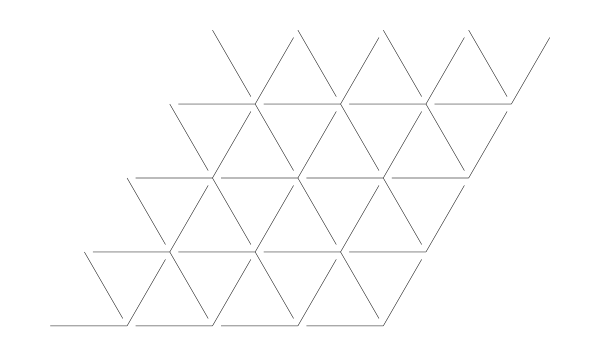

In [3]:
num_elem=3
theta=2*np.pi/num_elem

a=1.0
b=1.0
r0=0.9

lattice = [-a*np.exp(1j*theta),b] ## Lattice vectors

paths=[]

## primary linepiece
x0 = 0
x1 = -1*r0

## Construct the unit cell
unitcell = Path()
for i in range(num_elem - 1):
    unitcell.append(spt.Line(x0,x1*np.exp(i*1j*theta)))
    
unitcell.append(spt.Line(x0,x1*np.exp(-1j*theta)).translated(lattice[0] - lattice[1]))


nx=4
ny=4

for y in range(ny):
    for x in range(nx):
        print(i,j%2)
        paths.append(unitcell.translated(y*lattice[0] + x))
        
## Fence
# paths.append(spt.Line(-1,-1 + 1*nx))
# paths.append(spt.Line(-1,-1 + lattice[0]*ny))

# paths.append(spt.Line(-1 + lattice[0]*ny,
#                       -1 + 1*nx + lattice[0]*ny))

# paths.append(spt.Line(-1 + 1*nx,
#                         1*nx -1 + lattice[0]*ny))

disp_svg(paths)

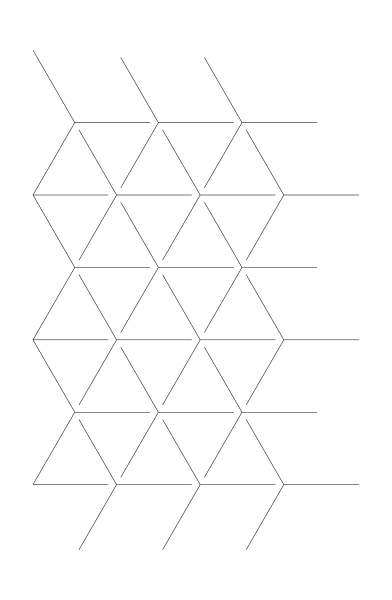

In [4]:
num_elem=3

## Angle as taken from 
theta=2*np.pi/num_elem

a=1.0
b=1.0
r0=0.9

## Basis vectors 
## Theta is considered to be starting from unit circle 0
basis = [1, np.exp(1j*(np.pi - theta))] 
b1,b2=basis

paths=[]

## primary linepiece (horizontal x)
## This one only goes to a fraction of the basis vector
x0,x1 = 0,r0*b1

## Construct the unit cell
unitcell = Path()
for n in range(num_elem):
    x,y =(x0,x1*np.exp(n*1j*theta))
    y=np.conjugate(y)  ## Flip because svg coord system
    unitcell.append(spt.Line(x,y))


### Edge elements
###
###
x0,x1 = 0,r0*b1

edge_l = Path()

## Line on right is still at r0
x,y =(x0,x1)
edge_l.append(spt.Line(x,y))
## Lines left are basis vector based.. i.e. full length
x0,x1 = 0,b1
for n in range(1,num_elem):
    x,y =(x0,x1*np.exp(n*1j*theta))
    y=np.conjugate(y)  ## Flip because svg coord system
    edge_l.append(spt.Line(x,y))



n_a1 =3 ## horizontal
n_a2 =6 ## vertical

for a2 in range(n_a2):
    for a1 in range(n_a1):
        elem = unitcell
        ## If on an even row shove the x-coordinate left
        if (a2%2):
            if (a1==0):
                elem=edge_l
            a1 -=1
            disp_b2_y = -np.imag(b2)*1j*a2 ## y displacement of basis vector 2
            disp_b2_x = np.real(b2)        ## x displacement (not multiplied)
            disp_b2 = disp_b2_y + disp_b2_x

            paths.append(elem.translated(a1*b1 + disp_b2))            
        else:
            
            disp_b2_y = -np.imag(b2)*1j*a2 ## y displacement of basis vector 2
            disp_b2_x = 0                  ## no x-displacement
            disp_b2 = disp_b2_y + disp_b2_x

            paths.append(elem.translated(a1*b1 + disp_b2))
            
            ## This add a line on odd rows to complement the edge cutoff
            if (a1==0):
                elem=edge_l
                paths.append(elem[0].translated(-b1 + disp_b2))
        
disp_svg(paths)

In [199]:
from dataclasses import dataclass
@dataclass
class vec2():
    x : float
    y : float
    
    @property
    def v(self):
        return np.array([self.x,self.y])#,dtype=float)

    ''' Complex representation'''    
    @property
    def c(self):
        return self.x + 1j*self.y

    def __add__(self, other):
        """Vector addition."""
        return vec2(self.x + other.x, self.y + other.y)

##REMEMBER SVG COORDINATE SYSTEM IS ORIGIN TOP-LEFT, Y increase goes down on the page
def get_poly_basis(num_elem=3):
    '''
        Get the polyhedron basis vectors
        first basis vector is v1 = (1,0) by default
        v2 is determined by the number of elements in the polyhedron
    '''
    theta=2*np.pi/num_elem
                    
    v1 = vec2(1,0)
    v_ = np.exp(1j*(np.pi - theta))
    v2 = vec2(np.real(v_), np.imag(v_))

    return v1,v2

v1,v2=get_poly_basis(4)
v1+v2

vec2(x=1.0, y=1.0)

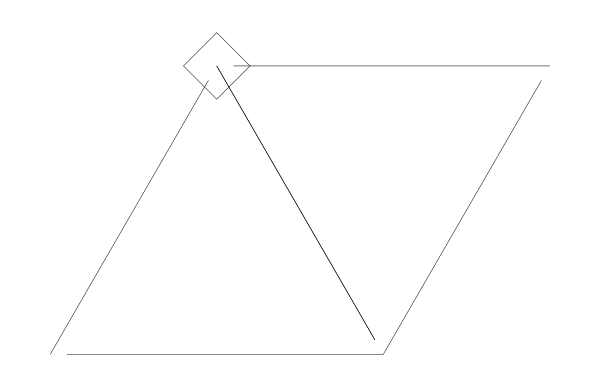

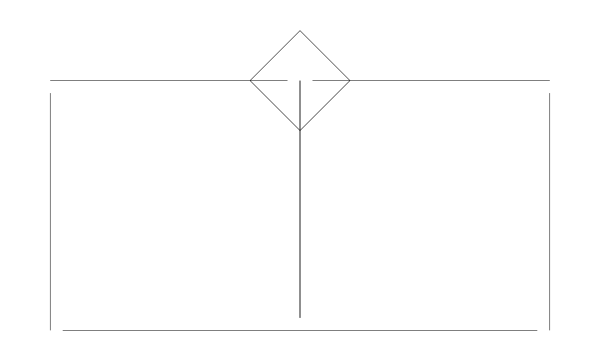

In [579]:

def get_poly(num_elem=3,
            invert=False,
            edge_extend=[],
            edge_omit=[],
            phase=False,
            R=0.95,
            scale=1):
    '''
        Get polyhedron
        num_elem, number of sides
        invert, invert horizontally or not, or..draw the other way round..
        edge_extend, list of edge numbers which are to be extended fully instead of upto R
        edge_omit, list of edges which should be omitted entirely
        phase, should the gap be first clockwise or counterclockwise
        R, how long should the line be (relative)
        scale, scaling factor for the edges
    '''

    theta=2*np.pi/num_elem
    v1,v2 = get_poly_basis(num_elem)

    ## Construct the unit cell
    unitcell = Path()
    #start,end coord
    r0=0
    r1=0
    #displacement
    d1=0
    ns = range(num_elem)
    # if phase:
    #     list(ns).reverse()
    
    ## Go through all linepieces
    ## Strategy is to rota
    for n in ns:
        ## Determine the rotation of a linepiece (before translation)
        if invert:
            rot = scale*np.conjugate(np.exp((n+2)*1j*theta))
        else:
            rot = scale*np.exp(n*1j*theta)
       
        ## Find edges that need to be fully extended
        if abs(n) in edge_extend:
            R_ = 1
        else:
            R_ = R
        
        if phase:
            r0,r1 = ((1-R_)*rot, rot)
        else:
            r0,r1 = (0, R_*rot)
        
        ## Append and translate according to base vector
        if not(n in edge_omit):
            unitcell.append(spt.Line(r0,r1).translated(d1))
        ## Starting position for the next linepiece is simply 
        d1 = d1 + rot
    
    return unitcell

# ## Two triangles, one upside down and displaced
# unitcell=get_poly(3, False,edge_extend=[1])
# unitcell2=get_poly(3, True,edge_extend=[1])
# disp_svg([unitcell,unitcell2])
testline = spt.polygon(-0.1,.1j,.1,-.1j)

# ## Two triangles, one upside down and displaced
unitcell=get_poly(3, invert=True,edge_extend=[],phase=True)
unitcell2=get_poly(3, invert=False,edge_extend=[],phase=True)

disp_svg([unitcell,unitcell2.translated(0),testline])


# ## Two squares, one upside down and displaced

unitcell=get_poly(4, invert=True,edge_extend=[],phase=True,scale=0.5)
unitcell2=get_poly(4, invert=False,edge_extend=[],phase=True,scale=0.5)

disp_svg([unitcell,unitcell2.translated(0),testline])

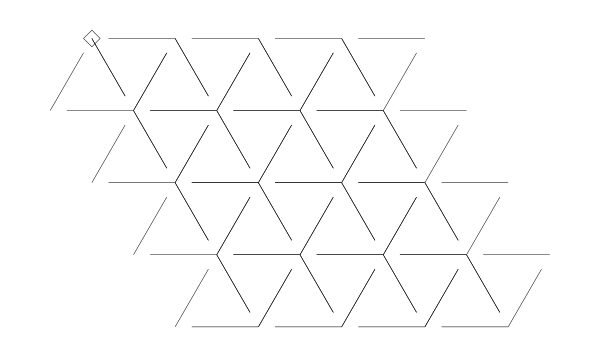

In [574]:
## Basis vectors 
## Theta is considered to be starting from unit circle 0

N_POLY = 3

##Basis vectors of lattice
v1,v2 = get_poly_basis(N_POLY)
paths=[]

n_a1 = 4
n_a2 = 4 ## vertical


for a2 in range(0,n_a2):
    for a1 in range(n_a1):
        elem1=get_poly(N_POLY, invert=True,edge_extend=[],phase=True,R=0.8)
        elem2=get_poly(N_POLY, invert=False,edge_extend=[],phase=True,R=0.8)


        v_d = v1.c*a1 + v2.c*a2 ##Displacement vector     
        paths.append(elem1.translated(v_d))
        paths.append(elem2.translated(v_d))

zero = spt.polygon(-0.1,.1j,.1,-.1j)
paths.append(zero)

disp_svg(paths)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
0
1
2
3
0
1
2
0
1
2


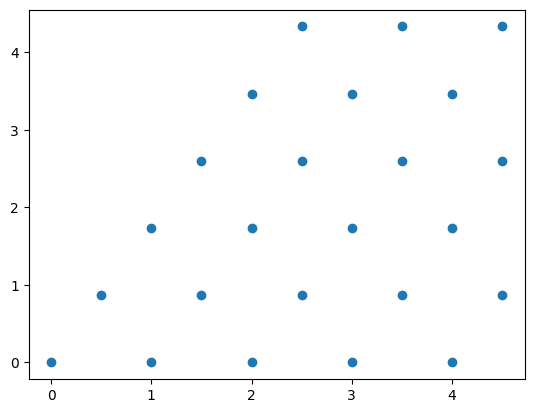

In [495]:
@dataclass
class BoxShape():
    l: float
    r: float
    u: float
    d: float

    def isin_mask(self, xs, ys):
        return (xs > self.l) & (xs < self.r) & (ys < self.u) & (ys > self.d)
@dataclass
class CircleShape():
    x0: float
    y0: float
    R0: float
    
    def isin_mask(self, xs, ys):
        return ((xs-self.x0)**2 + (ys-self.y0)**2) < self.R0**2


def construct_grid(v1,v2,shape,gridsize=(20,20)):
    a1,a2 = gridsize
    xs = np.arange(a1)
    ys = np.arange(a2)
    XS, YS = np.meshgrid(xs,ys)
    res = XS[:,:,np.newaxis]*v1.v + YS[:,:,np.newaxis]*v2.v
    import matplotlib.pyplot as plt
    x = res[:,:,0]
    y = res[:,:,1]

    mask = shape.isin_mask(x,y)
    # plt.scatter(x[mask],y[mask])
    ## Return coordinates and indices
    return res[mask],(XS[mask],YS[mask])
res, (xs_idx,ys_idx) = construct_grid(v1,v2,shape=CircleShape(5,5,5),gridsize=(20,20))
res, (xs_idx,ys_idx) = construct_grid(v1,v2,shape=BoxShape(-5,5,5,-5),gridsize=(20,20))

plt.scatter(res[:,0],res[:,1])
for _ in xs_idx:
    print(_)

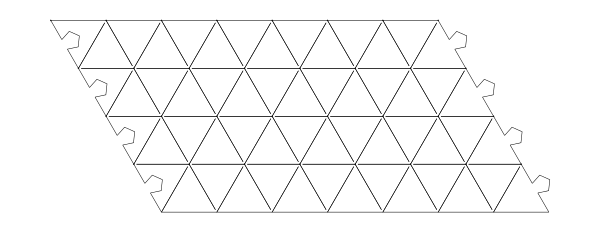

In [631]:
## Basis vectors 
## Theta is considered to be starting from unit circle 0

N_POLY = 3
R_POLY = 0.95

##Basis vectors of lattice
v1,v2 = get_poly_basis(N_POLY)
paths=[]

n_a1 = 8
n_a2 = 4 ## vertical

# n_a1 = 1
# n_a2 = 1 ## vertical
shape = BoxShape(1,8,5,-5)
shape = CircleShape(1,8,500)
gridpoints,(xs_idx,ys_idx) = construct_grid(v1,v2,shape=shape,gridsize=(n_a1,n_a2))

for (x,y), ix,iy in zip(gridpoints,xs_idx,ys_idx):
    edges_ext = []
    edges_ext += [2] if ix == n_a1-1 else [] ## Closing edges for left and right
    edges_ext += [1] if iy == n_a2-1 else [] ## Close "bottom"

    edges_omit = [2] if ix == n_a1-1 else []
    elem1=get_poly(N_POLY, 
                   invert=True,
                   edge_extend=edges_ext,
                   edge_omit=edges_omit,
                   phase=True,
                   R=R_POLY)
    edges_ext = []
    edges_ext += [2] if ix == 0 else []
    edges_ext += [0] if iy == 0 else [] ## Close "top"

    edges_omit = [2] if ix == 0 else []
    elem2=get_poly(N_POLY, 
                   invert=False,
                   edge_extend=edges_ext,
                   edge_omit=edges_omit,
                   phase=True,
                   R=R_POLY)
    cutfree = spt.polygon(-0.01,.01j,.01,-.01j)

    dovetail_scale = 0.2

    ## Some lines to make dovetail unit cell for an edge
    dv_pre = spt.Line(0,(1 - dovetail_scale)*v2.c/2)
    dv_post = spt.Line(-dovetail_scale*v2.c, -v2.c/2 - dovetail_scale/2*v2.c)
    dovetail = get_poly(5, invert=True,edge_extend=[],edge_omit=[4,],phase=True,R=1,scale=dovetail_scale)
    dovetail = dovetail.rotated(360/5 - 360/3 - 180,origin=0)
    dovetail.append(dv_pre)
    dovetail.append(dv_post)

    v_d = vec2(x,y) ##Displacement vector
    ## Take care of edge-cases..harhar
    if ix == 0:
        paths.append(dovetail
                     .translated(v_d.c + v2.c/2 + dovetail_scale/2*v2.c)
                    )
    if ix == n_a1-1:
        paths.append(dovetail
                     .translated(v_d.c + v2.c/2 + dovetail_scale/2*v2.c)
                    )
        
    if ix > 0: ## Don't use the left element for the left-most edge
        paths.append(elem1.translated(v_d.c))
    if ix < n_a1 -1: ## Don't use the right element of the unit cell for the right-most edge
        paths.append(elem2.translated(v_d.c))
    paths.append(cutfree.translated(v_d.c))

zero = spt.polygon(-0.1,.1j,.1,-.1j)
# paths.append(zero)

disp_svg(paths)

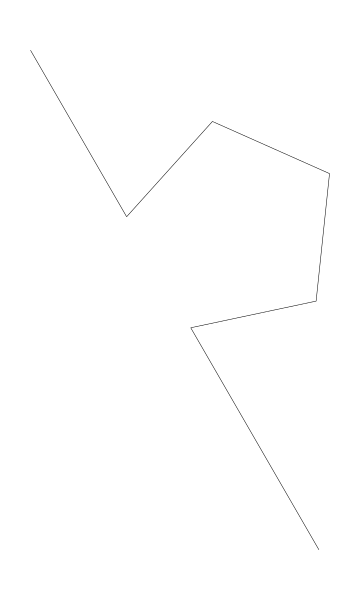

In [604]:
dovetail_scale = 0.2

## Some lines to make dovetail unit cell for an edge
dv_pre = spt.Line(0,(1 - dovetail_scale)*v2.c/2)
dv_post = spt.Line(-dovetail_scale*v2.c, -v2.c/2)
dovetail = get_poly(5, invert=True,edge_extend=[],edge_omit=[4,],phase=True,R=1,scale=dovetail_scale)
dovetail = dovetail.rotated(360/5 - 360/3 - 180,origin=0)
dovetail.append(dv_pre)
dovetail.append(dv_post)
disp_svg(dovetail)

In [470]:
line1 = spt.Line(0,1)
line2 = spt.Line(0,1+0.0001j)
line2 = spt.Line(1+0.0001j,0)
line3 = spt.Line(0,1+0.5j)
def test_approx_equal(line1,line2, tol=1e-3):

    ## FIXME: Should check for flipped direction
    forward_match =  abs((line1.end - line2.end)) < tol and \
                     (abs(line1.start - line2.start) < tol)
    reverse_match = abs((line1.end - line2.start)) < tol and \
                     (abs(line1.start - line2.end) < tol)

    return forward_match or reverse_match
test_approx_equal(line1,line3)

False

Removed 52 lines


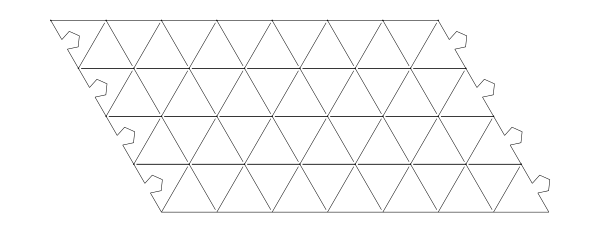

In [632]:
## Find duplicates in paths
seen = []
def check_seen(line):
    for s in seen:
        if test_approx_equal(line,s):
            return True
    return False

all_lines = spt.Path()
removed_count = 0
for path in paths:
    for line in path._segments:
        if check_seen(line):
            path.remove(line)
            removed_count+=1
            # print(f'removing {line}')
        else:
            # print(f'didnt see {line}, appending')
            seen.append(line)
        
print(f'Removed {removed_count} lines')
disp_svg(paths)

In [633]:
save_svg(paths, name='aux', params='withdovetail')